## To-do
* train model on all sites combined
    * seasons are opposite in southern hemisphere 
    * not all cities contribute the same amount of data points 
        * make differently sized datasets equally valuable, leave a few (3? one for each pollution type) datasets out for testing
* create model of form: N100 = a + exp(b\*T + c) + d\*CO
    * don't transform N100
    * train sub-model for temperature
        * use result and CO as input for final model 
    * train multiple sub-models (2?) and combine them
        * depending on temperature: when the temperature is high, CO should be almost irrelevant
        * use k-means to split data into two sets (two peaks in data)

## Notes
* **Data**
    * use additional data
        * precipitation 
        * boundary layer height
    * remove outliers before normalizing? 
        * how to identify outliers?
    * focus on HYY, KPZ, NAN, MLP for now, then look at data from all cities combined
        * NAN (high pollution) and KPZ (medium pollution) are very small datasets
        * MLP is a moderately small dataset and has high pollution
        * HYY is the biggest dataset and has low pollution
    
* **Model**
    * look into interpretability of random forest models or using a combination of decision trees and linear regression models
        * random forests perform a lot better than linear regression
    
## Results
* using sin and cos of day of the year makes model performance worse, using the month improves it a bit, season and week of the year don't change much from month of the year
    * using 10 "seasons" gives best results
* most errors seem to occur in the summer
* high N100 concentrations are strongly underestimated
* **predictor combinations**
    * one predictor
        * **T: 0.188**
        * CO: -0.067
        * Season: 0.142
    * two predictors
        * **T, CO: 0.256**
        * T, PWA: 0.240
        * T, Season: 0.233
    * three predictors
        * T, CO, Season: 0.244
        * **T, CO, PWA: 0.275**
        * T, PWA, Season: 0.260
        * CO, PWA, Season: 0.192
    * four predictors
        * **T, CO, PWA, Season: 0.292**

### Strength of predictors
1. Temperature
2. Carbon Monoxide
3. Previous Week Average
4. Season

## Importing Libraries

In [1]:
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

## Initiating directories

In [2]:
ROOT_DIR = os.getcwd() + '/../'
try:
    with open (ROOT_DIR + '/configuration.yml', 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print('Error reading the config file')
DATA_DIR = ROOT_DIR + config['data']['final'] + '/'
cities = pd.read_csv(ROOT_DIR + config['cities'])

### City abbreviations

* **ALE:**	Alert, Canada
* **ABZ:**	Annaberg-Buchholz, Germany
* **ASP:**	Aspvreten, Sweden
* **BOT:**	Botsalano, South Africa
* **BSL:**	Bösel (Südoldenburg), Germany
* **EGB:**	Egbert, Canada
* **HEL:**	Helsinki, Finland
* **HPB:**	Hohenpeissenberg, Germany
* **HYY:**	Hyytiälä, Finland
* **KCE:**	Kosetice, Czech Republic
* **KPZ:**	K-Puszta, Hungary
* **MHD:**	Mace Head, Ireland
* **MAR:**	Marikana, South Africa
* **MLP:**	Melpitz, Germany
* **NAN:**	Nanjing, China
* **NEU:**	Neuglobsow, Germany
* **SAO:**	São Paulo, Brazil
* **SCH:**	Schauinsland, Germany
* **SGP:**	Southern Great Plains, Oklahoma, US
* **VIE:**	Vielsalm, Belgium
* **VAR:**	Värriö, Finland
* **WAL:**	Waldhof, Germany


## Loading and pre-processing the data
### Selecting a city

In [3]:
print('All cities:')
print(cities.city.unique(), '\n')

city = 'HYY'
print('Selected:', city)

All cities:
['ALE' 'ABZ' 'ASP' 'BOT' 'BSL' 'EGB' 'HEL' 'HPB' 'HYY' 'KCE' 'KPZ' 'MHD'
 'MAR' 'MLP' 'NAN' 'NEU' 'SAO' 'SCH' 'SGP' 'VIE' 'VAR' 'WAL'] 

Selected: HYY


### Selecting which predictors to use in the model

In [4]:
use_t = True
use_co = True
use_pwa = True
use_season = True

predictors = []
eq_variables = []

if use_t:
    predictors.append('t')
    eq_variables.append('min_max(T)')
    if use_pwa:
        predictors.append('t_pwa')
        eq_variables.append('min_max(T_PWA)')
if use_co:
    predictors.append('co')
    eq_variables.append('log(CO)')
    if use_pwa:
        predictors.append('co_pwa')
        eq_variables.append('log(CO_PWA)')
if use_season:
    predictors.extend(['season_sin', 'season_cos'])
    eq_variables.extend(['sin(Season)', 'cos(Season)'])
    
print('Using predictors:', predictors)

Using predictors: ['t', 't_pwa', 'co', 'co_pwa', 'season_sin', 'season_cos']


### Creating the dataset

In [5]:
# loading the data
df = pd.read_csv(DATA_DIR + city + '.csv', index_col='date')

# renaming the columns
df.columns = ['n100', 't', 'co']

if use_season:
    # calculating the day of the year in order to get the season
    no_seasons = 10  # number of seasons per year
    dates = df.index.tolist()
    season = [datetime.datetime.strptime(dates[i], "%Y-%m-%d").date() for i in range(len(dates))]
    season = np.array([season[i].timetuple().tm_yday for i in range(len(season))])
    season = season / (365/no_seasons)
    season = np.round(season)

    # adding the sin and cos of season to the dataframe
    df['season_sin'] = np.sin(2*np.pi * season/len(np.unique(season)))
    df['season_cos'] = np.cos(2*np.pi * season/len(np.unique(season)))

if use_pwa:
    # adding averages of the previous week (pwa) of t (t_pwa) and co (co_pwa) values to the df 
    # (excluding the day measured in t and co)
    pwa = 7
    for col in ['t', 'co']:
        new_df = pd.DataFrame()
        for i in range(1, pwa+1):
            new_df[col + '_' + str(i)] = df.shift(i)[col]
        new_df = new_df.aggregate(np.mean, axis=1)
        df[col + '_pwa'] = new_df

    # removing the rows containing NaN values in the previous 7 days
    df = df[pwa:]
    dates = dates[pwa:]

# setting all values that are equal to 0 to 0.000001 to avoid infinities
df[df == 0] = 0.000001

# reordering columns
df = df[['n100'] + predictors]

print('Number of data points:', df.shape[0])
df.head()

Number of data points: 5814


,n100,t,t_pwa,co,co_pwa,season_sin,season_cos
date,,,,,,,
2003-01-08,648.683077,263.04785,249.529120,1.922008e-07,2.222959e-07,0.000001,1.0
2003-01-09,177.328356,262.86664,251.343464,1.693421e-07,2.169822e-07,0.000001,1.0
2003-01-10,515.932024,251.66493,253.066070,1.946702e-07,2.054784e-07,0.000001,1.0
2003-01-11,285.454347,260.85300,253.566986,1.861436e-07,1.959475e-07,0.000001,1.0
2003-01-12,232.010139,265.06660,255.566956,1.722488e-07,1.922792e-07,0.000001,1.0


### Transforming the data

In [6]:
# normalizing the data
min_max_scaler = preprocessing.MinMaxScaler()
scaler_idx = 1 + len(predictors) - use_season*2
x_scaled = min_max_scaler.fit_transform(df.iloc[:,0:scaler_idx].values)
x_scaled = np.concatenate((x_scaled, df.iloc[:,scaler_idx:].values), axis=1)

df_scaled = pd.DataFrame(x_scaled)
df_scaled.columns = df.columns.values

# log-transforming the data
df_log = df_scaled.transform(np.log)

### Removing rows that contain infinities

In [7]:
subset_mask = np.isinf(df_log).any(axis=1) == False

df = df.reset_index(drop=True).loc[subset_mask]
df_log = df_log.loc[subset_mask]
df_scaled = df_scaled.loc[subset_mask]
dates = pd.Series(dates).loc[subset_mask]

print('Number of removed rows:', sum(subset_mask ==False))

Number of removed rows: 5


### Combining the transformed datasets into one dataframe

In [8]:
df_comb = [df_log.n100]  # log-transformed N100 concentration

if use_t:
    df_comb.append(df_scaled.t)  # min-max scaled temperature
    if use_pwa:
        df_comb.append(df_scaled.t_pwa)  # PWA of min-max scaled temperature
if use_co:
    df_comb.append(df_log.co)  # log-transformed CO concentration
    if use_pwa:
        df_comb.append(df_log.co_pwa)  # PWA of log-transformed CO concentration
if use_season:
    df_comb.extend([df.season_sin, df.season_cos])  # sin and cos of seasons

df_comb = pd.DataFrame(np.array(df_comb).T)
df_comb.columns = df.columns.values
df_comb.head()

,n100,t,t_pwa,co,co_pwa,season_sin,season_cos
0,-3.192179,0.307211,0.037555,-0.960064,-0.220608,0.000001,1.0
1,-2.032946,0.091367,0.073212,-0.720138,-0.308944,0.000001,1.0
2,-2.662417,0.268411,0.083580,-0.794658,-0.388547,0.000001,1.0
3,-2.889661,0.349602,0.124978,-0.929420,-0.420956,0.000001,1.0
4,-3.700188,0.409175,0.173868,-1.124569,-0.452693,0.000001,1.0


### Calculating moving averages

In [11]:
window_size = 30
df_comb_ma = df_comb.copy().rolling(window=window_size).mean()[window_size:]

## Visualizations
### Value distributions

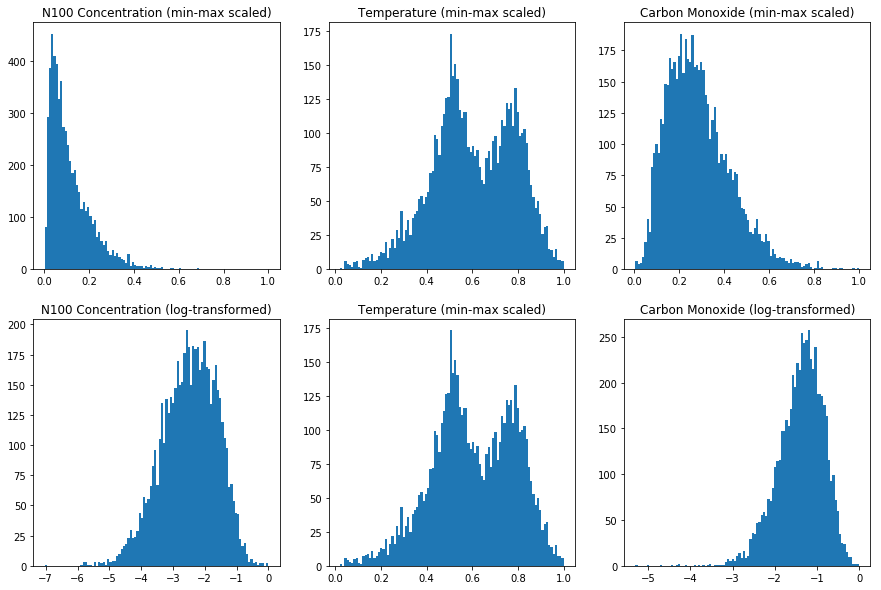

In [14]:
fig, ax = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)

ax[0, 0].hist(df_scaled.n100, bins=100)
ax[0, 1].hist(df_scaled.t, bins=100)
ax[0, 2].hist(df_scaled.co, bins=100)

ax[1, 0].hist(df_comb.n100, bins=100)
ax[1, 1].hist(df_comb.t, bins=100)
ax[1, 2].hist(df_comb.co, bins=100)

ax[0, 0].set_title('N100 Concentration (min-max scaled)')
ax[0, 1].set_title('Temperature (min-max scaled)')
ax[0, 2].set_title('Carbon Monoxide (min-max scaled)')

ax[1, 0].set_title('N100 Concentration (log-transformed)')
ax[1, 1].set_title('Temperature (min-max scaled)')
ax[1, 2].set_title('Carbon Monoxide (log-transformed)');

N100 Concentration and Carbon Monoxide have a high positive skew and should therefore be log-tranformed

### Plotting the transformed data and moving averages

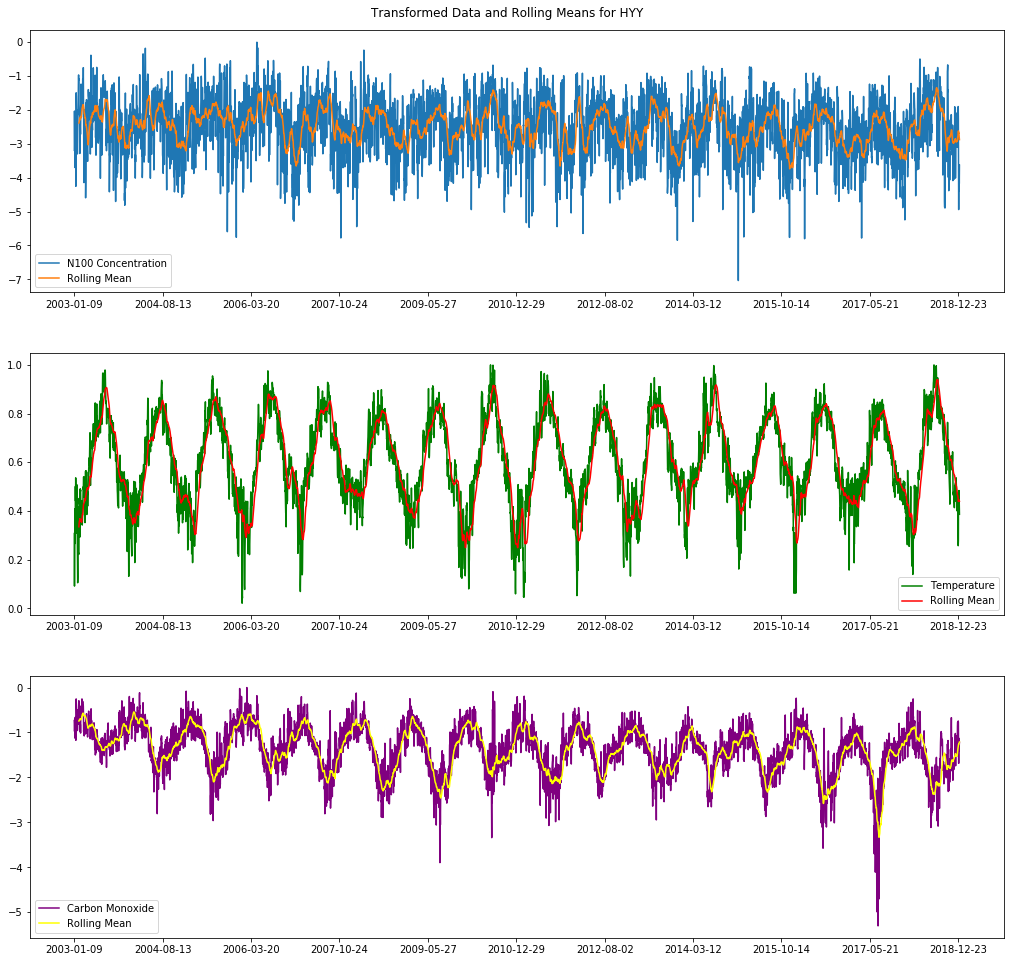

In [16]:
idx = df_log.shape[0]
step = int(idx / 10)
xticks_mask = list(range(0, idx, step))
xticks = pd.Series(dates).iloc[xticks_mask]

fig, ax = plt.subplots(3, 1)
fig.set_size_inches(15,14)

ax[0].plot(df_comb.n100[:idx], label='N100 Concentration')
ax[0].plot(df_comb_ma.n100[:idx], label='Rolling Mean')

ax[1].plot(df_comb.t[:idx], label='Temperature', c='green')
ax[1].plot(df_comb_ma.t[:idx], label='Rolling Mean', c='red')

ax[2].plot(df_comb.co[:idx], label='Carbon Monoxide', c='purple')
ax[2].plot(df_comb_ma.co[:idx], label='Rolling Mean', c='yellow')

for i in range(3):
    ax[i].legend()
    ax[i].set_xticks(xticks_mask)
    ax[i].set_xticklabels(xticks)

fig.tight_layout(pad=4)
fig.suptitle('Transformed Data and Rolling Means for '+city);

### Plotting correlations of N100 concentration vs. predictors 

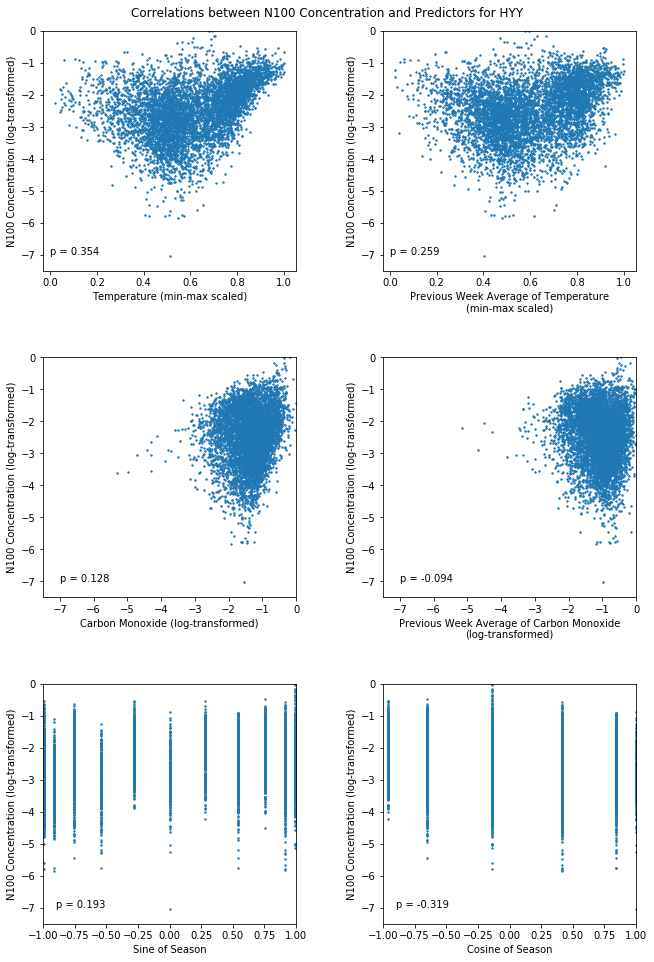

In [17]:
rows = 3
cols = 2

fig, ax = plt.subplots(rows, cols)
fig.set_size_inches(10,14)
fig.suptitle('Correlations between N100 Concentration and Predictors for '+city)

# plotting the data
ax[0, 0].scatter(df_comb.t, df_log.n100, s=2)
ax[0, 1].scatter(df_comb.t_pwa, df_log.n100, s=2)
ax[1, 0].scatter(df_comb.co, df_log.n100, s=2)
ax[1, 1].scatter(df_comb.co_pwa, df_log.n100, s=2)
ax[2, 0].scatter(df_comb.season_sin, df_log.n100, s=2)
ax[2, 1].scatter(df_comb.season_cos, df_log.n100, s=2)

# setting x-axis limits
ax[1, 0].set_xlim(-7.5, 0)
ax[1, 1].set_xlim(-7.5, 0)
ax[2, 0].set_xlim(-1, 1)
ax[2, 1].set_xlim(-1, 1)

# labelling the axes
ax[0, 0].set_xlabel('Temperature (min-max scaled)')
ax[0, 1].set_xlabel('Previous Week Average of Temperature\n(min-max scaled)')
ax[1, 0].set_xlabel('Carbon Monoxide (log-transformed)')
ax[1, 1].set_xlabel('Previous Week Average of Carbon Monoxide\n(log-transformed)')
ax[2, 0].set_xlabel('Sine of Season')
ax[2, 1].set_xlabel('Cosine of Season')

for i in range(rows):
    for j in range(cols):
        ax[i, j].set_ylim(-7.5, 0)
        ax[i, j].set_ylabel('N100 Concentration (log-transformed)')

# adding correlation coefficients
def get_corr(a, b, pr=3):
    corr = np.corrcoef(a, b)[0,1]
    corr = np.round(corr, pr)
    return str(corr)

ax[0, 0].text(0, -7, 'p = ' + get_corr(df_comb.t, df_comb.n100))
ax[0, 1].text(0, -7, 'p = ' + get_corr(df_comb.t_pwa, df_comb.n100))
ax[1, 0].text(-7, -7, 'p = ' + get_corr(df_comb.co, df_comb.n100))
ax[1, 1].text(-7, -7, 'p = ' + get_corr(df_comb.co_pwa, df_comb.n100))
ax[2, 0].text(-0.9, -7, 'p = ' + get_corr(df_comb.season_sin, df_comb.n100))
ax[2, 1].text(-0.9, -7, 'p = ' + get_corr(df_comb.season_cos, df_comb.n100))

fig.tight_layout(pad=4);

## Modelling
### Preparing the data

In [21]:
# splitting the data into training (75%) and testing (25%) sets
split = int(len(df_comb) * 0.75)  # index to split the data on

# dates
dates_test = dates[split:len(df)]

# n100
y_train= df_comb.n100[0:split]
y_test = df.n100[split:len(df)].reset_index(drop=True)
log_y_test = df_comb.n100[split:len(df)].reset_index(drop=True)

# predictors
X_train = df_comb[predictors][0:split]
X_test = df_comb[predictors][split:len(df_comb)].reset_index(drop=True)

# fitting a min_max_scaler to the concentration data so that predicted values can be reverse transformed
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler = min_max_scaler.fit(df.n100.values.reshape(-1,1))

print('Predictors:', predictors, '\n')
print('Training data shapes:', X_train.shape, 'and', y_train.shape)
print('Testing data shapes:', X_test.shape, 'and', y_test.shape)

Predictors: ['t', 't_pwa', 'co', 'co_pwa', 'season_sin', 'season_cos'] 

Training data shapes: (4356, 6) and (4356,)
Testing data shapes: (1453, 6) and (1453,)


### Functions for evaluating the models

In [22]:
pr = 3  # precision to be used for printing results

# function for reverse transforming the data
def rev_trans(predictions):
    predictions = np.exp(predictions)
    predictions = min_max_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions

# function for printing the equation created by the linear regression model
def print_equation(model):
    coefs = np.round(model.coef_, pr)
    intercept = np.round(model.intercept_, pr)
    
    equation = 'Model equation:\nlog(N100) ='
    
    for i in range(len(coefs)):
        if coefs[i] < 0:
            equation += ' - '
        elif i == 0:
            equation += ' '
        else:
            equation += ' + '
        
        equation += str(np.abs(coefs[i]))
        equation += '*' + eq_variables[i]
    
    if intercept < 0:
        equation += ' - '
    else:
        equation += ' + '
    
    equation += str(np.abs(intercept)) + '\n'               
    print(equation)

# function for calculating the R2 value and RMSE
def eval_model(predictions, model):
    r2 = r2_score(y_test, predictions)
    print('R2 score:\n%.3f\n' % r2)
    
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print('RMSE on test set:\n%.3f\n' % rmse)

# function for plotting the log-transformed observed and predicted n100 concentrations against each other
def log_log_eval(log_predictions):
    plt.figure(figsize=(5, 5))
    plt.title('Observed vs. Predicted Log-Transformed N100 Concentration')
    
    axis_min, axis_max = -7, 0
    
    # plotting the line of perfect fit
    plt.plot(list(range(axis_min, axis_max+1)), list(range(axis_min, axis_max+1)), c='black', alpha=0.25)
    
    # plotting a line fitting the data
    poly = np.polyfit(log_y_test, log_predictions, 1)
    x = np.linspace(axis_min, axis_max, 100)
    y = poly[0]*x + poly[1]
    plt.plot(x, y, c='orange', alpha=0.75)
    
    # plotting the data
    plt.scatter(log_y_test, log_predictions, s=2)
    
    plt.xlim(axis_min, axis_max)
    plt.ylim(axis_min, axis_max)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    print('Correlation between observed and predicted log-transformed N100 concentration:\n%.3f\n' %
          np.corrcoef(log_y_test, log_predictions)[0, 1])

# function for plotting the observed and predicted n100 concentrations against each other
def corr_eval(predictions):
    plt.figure(figsize=(5, 5))
    plt.title('Observed vs. Predicted N100 Concentration')
    
    axis_min, axis_max = 0, int(y_test.max())
    
    # plotting the line of perfect fit
    plt.plot(list(range(axis_min, axis_max+1)), list(range(axis_min, axis_max+1)), c='black', alpha=0.25)
    
    # plotting a line fitting the data
    poly = np.polyfit(y_test, predictions, 1)
    x = np.linspace(axis_min, axis_max, 100)
    y = poly[0]*x + poly[1]
    plt.plot(x, y, c='orange', alpha=0.75)
    
    # plotting the data
    plt.scatter(y_test, predictions, s=2, )
    
    plt.xlim(axis_min, axis_max)
    plt.ylim(axis_min, axis_max)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    print('Correlation between observed and predicted N100 concentration:\n%.3f\n' %
          np.corrcoef(y_test, predictions[:,0])[0, 1])
    
# function for plotting the predicted and observed n100 concentrations
def plot_results(name, predictions):
    plt.figure(figsize=(15,5))
    plt.title('Performance of ' + name + ' Model - Test Set')
    
    plt.plot(np.array(y_test), label='Observed')
    plt.plot(predictions, label='Predicted')
    
    xticks_mask = list(range(0, dates_test.shape[0], int(dates_test.shape[0] / 8)))
    xticks = dates_test.iloc[xticks_mask]
    plt.xticks(xticks_mask, xticks)
    
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('N100 concentration')

### Linear Regression

Model equation:
log(N100) = 2.275*min_max(T) - 1.111*min_max(T_PWA) + 1.456*log(CO) - 0.703*log(CO_PWA) + 0.139*sin(Season) - 0.493*cos(Season) - 2.0

Correlation between observed and predicted log-transformed N100 concentration:
0.584

Correlation between observed and predicted N100 concentration:
0.571

R2 score:
0.292

RMSE on test set:
271.779



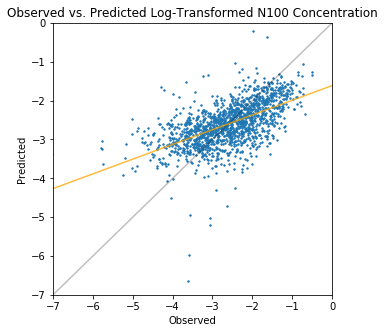

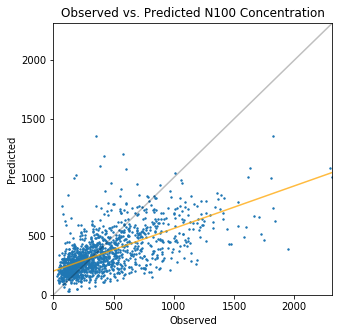

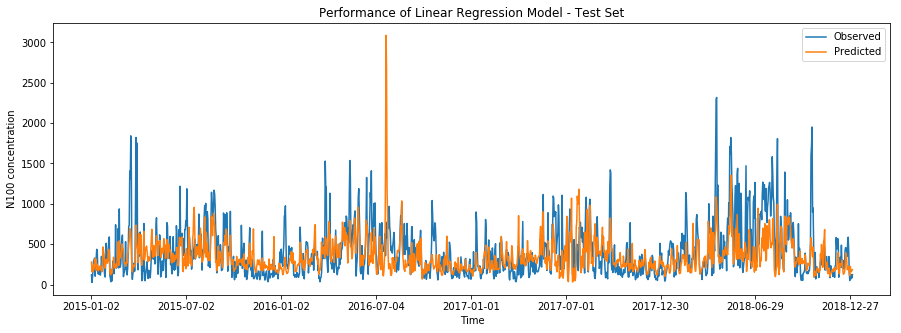

In [23]:
# Linear Regression
model = LinearRegression().fit(X_train, y_train)
predictions = model.predict(X_test)

# model evaluation
print_equation(model)
log_log_eval(predictions)

predictions = rev_trans(predictions)
corr_eval(predictions)
eval_model(predictions, model)
plot_results('Linear Regression', predictions)

### Random Forest Regression

Correlation between observed and predicted log-transformed N100 concentration:
0.724

Correlation between observed and predicted N100 concentration:
0.737

R2 score:
0.513

RMSE on test set:
225.323



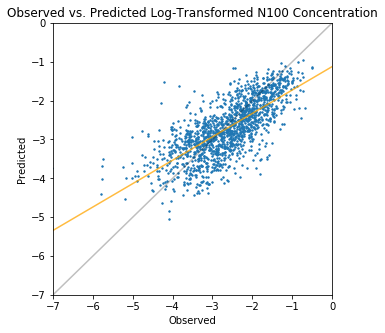

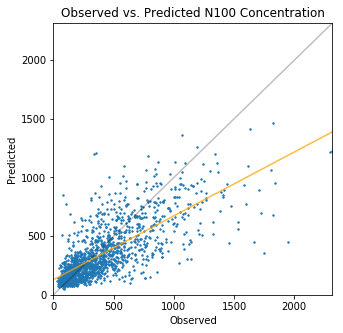

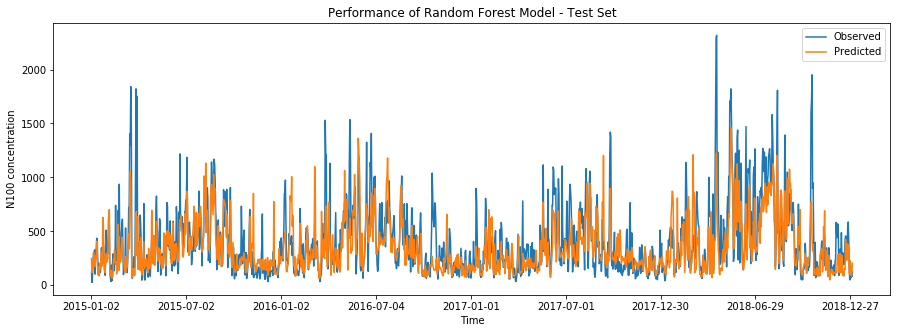

In [24]:
# Random Forest
model = RandomForestRegressor(n_estimators=15).fit(X_train, y_train)
predictions = model.predict(X_test)

# model evaluation
log_log_eval(predictions)

predictions = rev_trans(predictions)
corr_eval(predictions)
eval_model(predictions, model)
plot_results('Random Forest', predictions)

The random forest model seems to give by far the best performance but is a black-box algorithm